# 2018 11 02 Optimisation des Gabors
Youpi ça marche, maintenant il me faut une fonction de sauvegarde des courants de chaque filtre pour pouvoir les inputs sur une cellule V1

Il faut tout passer en fonction

Puis passer en mutlithreading

Et faire des bugfixes

Il est 14h, en avant guingamp


# Partie 1 : Fonctions pour faire de la connectivité en Gabor

In [1]:
# les classiques


def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X, Y = np.meshgrid(x, y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z


def temporal_filter(t=1, response_time=175, refrac_time=50,
                    K1=.92, c1=0.2, n1=7, t1=-6,
                    K2=.2, c2=.12, n2=8, t2=-6,
                    baseline=0., gain=90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''

    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ((c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / \
        (n1**2)*np.exp(-n1)
    p -= K2 * ((c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / \
        (n2**2)*np.exp(-n2)
    return p*gain  # oups je me suis planté d'un facteur 90, c'est un sacré miss

In [2]:
# les gabors


def generate_small_gabors(params, N_X, N_Y, N_theta, centers_coordinates, nbr_gabors=6,
                          B_theta=15, sf_0=.05, B_sf=.5):
    '''
    UNUSED
    Given some gabor parameters, a set of coordinates for centering gabors, returns
    a bunch of gabors' phi-space per each theta
    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        centers_coordinates : a 2D array containing two list of coordinates for
                                centering the gabors
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape
    '''

    xs = centers_coordinates[0]
    ys = centers_coordinates[1]

    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta / 180 * np.pi
    params = {'sf_0': sf_0, 'B_sf': B_sf, 'B_theta': B_theta}
    thetas = np.linspace(0, np.pi, N_theta)

    theta_phi_list = []
    for t in range(N_theta):
        phi = np.zeros((1, N_phase, N_X, N_Y))
        theta = thetas[t]
        params.update(theta=theta)

        phi_list = []
        for gab in range(nbr_gabors):
            x = xs[gab]
            y = ys[gab]

            for i_phase in range(N_phase):
                phase = i_phase * np.pi/2
                kernel = lg.invert(lg.loggabor(
                    x, y, **params)*np.exp(-1j*phase))
                phi[0, i_phase, :] = lg.normalize(kernel)

            phi_list.append(phi)
        theta_phi_list.append(phi_list)
    return theta_phi_list


def gabor_connectivity(filters, phi, theta, threshold, on=True):
    '''
    From an array of filters and a gabor phi-space, returns the filters in the phi-space above a threshold
    Args :
        Filters (ndarray) : A 2D array of filters to localize on the gabor
        Phi : A phi space from a LogGabor
        Threshold : the threshold above which (or below, given 'on' param) we select the filters
        on : True if we're passing on center filters, False if we're doing off center filters
    '''
    if on:
        gab_above_threshold = np.array(
            [*np.where(phi[theta, 0] > threshold)], dtype=float).T
    else:
        gab_above_threshold = np.array(
            [*np.where(phi[theta, 0] < threshold)], dtype=float).T

    filters_in_gabor = []
    for it, filt in enumerate(filters):
        for gabs in gab_above_threshold:
            if np.all(filt.astype(int) == gabs):
                filters_in_gabor.append(filt)

    return filters_in_gabor

In [3]:
def generate_small_gabors_coordinates(params, N_X, N_Y, N_theta, centers_coordinates, nbr_gabors=6,
                                      B_theta=15, sf_0=.05, B_sf=.5,
                                      distrib_size=8, grid_res=3, on_thresh=.1, off_thresh=-.1,
                                      verbose=True):
    '''
    Given some gabor parameters, a set of coordinates for centering gabors, returns a set of 
    coordinates for filters belonging into the gabors

    The code iterates through thetas and generate nbr_gabors set of ON/OFF filters

    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        centers_coordinates : a 2D array containing two list of coordinates for
                                centering the gabors
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape, 
                                B_theta being the opening of the gabor, sf_0 the spatia frequency 
                                and b_sf the bandwidth frequency
    '''

    xs = centers_coordinates[0]
    ys = centers_coordinates[1]

    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta / 180 * np.pi
    params = {'sf_0': sf_0, 'B_sf': B_sf, 'B_theta': B_theta}
    thetas = np.linspace(0, np.pi, N_theta)

    filters_per_theta = []
    for t in range(N_theta):
        phi = np.zeros((1, N_phase, N_X, N_Y))
        theta = thetas[t]
        params.update(theta=theta)

        filters_per_gab = []
        for gab in range(nbr_gabors):
            x = xs[gab]
            y = ys[gab]

            for i_phase in range(N_phase):
                phase = i_phase * np.pi/2
                kernel = lg.invert(lg.loggabor(
                    x, y, **params)*np.exp(-1j*phase))
                phi[0, i_phase, :] = lg.normalize(kernel)

            fx_min = x - distrib_size
            fx_max = x + distrib_size
            fy_min = y - distrib_size
            fy_max = y + distrib_size
            filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,
                                           fy_min:fy_max:grid_res].reshape(2, -1).T
            if verbose and t == 0 and gab == 0:
                print('Filter grid shape', filters_coordinates.shape)

            filters_in_gabor = gabor_connectivity(filters=filters_coordinates,
                                                  phi=phi, theta=0, threshold=on_thresh)
            off_filters_in_gabor = gabor_connectivity(filters=filters_coordinates,
                                                      phi=phi, theta=0, threshold=off_thresh, on=False)

            filters_per_gab.append((filters_in_gabor, off_filters_in_gabor))

        filters_per_theta.append(filters_per_gab)

    return filters_per_theta

In [4]:
def generate_big_gabors_coordinates(params, N_X, N_Y, N_theta, center_coordinates,
                                    B_theta=15, sf_0=.075, B_sf=.7,
                                    distrib_size=25, grid_res=3, on_thresh=.1, off_thresh=-.1,
                                    verbose=True):
    '''
    Given some gabor parameters, a set of coordinates for centering gabors, returns a set of 
    coordinates for filters belonging into the one gabor per theta

    The code iterates through thetas and generate one gabor set of ON/OFF filters per theta

    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        center_coordinates : a 2D array containing two ints for the center of the big gabor
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape, 
                                B_theta being the opening of the gabor, sf_0 the spatia frequency 
                                and b_sf the bandwidth frequency
    '''

    x = center_coordinates[0]
    y = center_coordinates[1]

    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta / 180 * np.pi
    params = {'sf_0': sf_0, 'B_sf': B_sf, 'B_theta': B_theta}
    thetas = np.linspace(0, np.pi, N_theta)

    filters_per_theta = []
    for t in range(N_theta):
        phi = np.zeros((1, N_phase, N_X, N_Y))
        theta = thetas[t]
        params.update(theta=theta)

        for i_phase in range(N_phase):
            phase = i_phase * np.pi/2
            kernel = lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))
            phi[0, i_phase, :] = lg.normalize(kernel)

        fx_min = x - distrib_size
        fx_max = x + distrib_size
        fy_min = y - distrib_size
        fy_max = y + distrib_size
        filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,
                                       fy_min:fy_max:grid_res].reshape(2, -1).T
        if verbose and t == 0:
            print('Filter grid shape', filters_coordinates.shape)

        filters_in_gabor = gabor_connectivity(filters=filters_coordinates,
                                              phi=phi, theta=0, threshold=on_thresh)
        off_filters_in_gabor = gabor_connectivity(filters=filters_coordinates,
                                                  phi=phi, theta=0, threshold=off_thresh, on=False)

        filters_per_theta.append((filters_in_gabor, off_filters_in_gabor))

    return filters_per_theta

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from LogGabor import LogGabor

############
# Constantes
############
gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                        'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                        'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                        'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                        'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                        'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                        'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                        'white_recompute': False, 'white_steepness': 4.0}

video = np.load('../montypython.npy')
video = np.rot90(video)
print('Video shape', video.shape)

total_time = 1000  # ms, temps de simulation
filter_size = 2.

distrib_size = 8
grid_res = 3

centers_coordinates = np.array(
    [[35, 20, 35, 10, 20, 35], [35, 20, 10, 35, 35, 20]])

Video shape (54, 54, 4096)


In [6]:
gsgc = generate_small_gabors_coordinates(params=gabors_parameterfile, N_X=54, N_Y=54, N_theta=12,
                                         centers_coordinates=centers_coordinates, distrib_size=distrib_size,
                                         grid_res=grid_res)

Filter grid shape (36, 2)


In [7]:
# Data structure is, per list index, gsgc[theta][gabor][0=ON;1=OFF][specific tuple of coordinates]
print('Example : ')
print(gsgc[0][4][0])

Example : 
[array([18, 27]), array([18, 30]), array([18, 33]), array([18, 36]), array([18, 39]), array([18, 42]), array([21, 27]), array([21, 30]), array([21, 33]), array([21, 36]), array([21, 39]), array([21, 42])]


In [8]:
gbgc = generate_big_gabors_coordinates(params=gabors_parameterfile, N_X=54, N_Y=54, N_theta=12,
                                       center_coordinates=np.array([[27], [27]]))

Filter grid shape (289, 2)


In [9]:
# For big gabor data structure is gbgc[theta][0=ON;1=OFF][specific tuple of coordinates]
print('Example : ')
print(gbgc[0][1])

Example : 
[array([20, 20]), array([20, 23]), array([20, 26]), array([20, 29]), array([20, 32]), array([20, 35]), array([23, 23]), array([23, 26]), array([23, 29]), array([23, 32]), array([32, 20]), array([32, 23]), array([32, 26]), array([32, 29]), array([32, 32]), array([35, 20]), array([35, 23]), array([35, 26]), array([35, 29]), array([35, 32])]


# Partie 2 : Génerer des courants à partir des filtres

In [10]:
def coordinates_to_currents(filters_in_gabor, off_filters_in_gabor,
                            stimuli, total_time, filter_size, filter_res):
    '''
    Creates currents from spatiotemporal filters in given coordinates set, by convolving
    the apex of the ST filter with the receptive field in a fed video

    Args :
        filters_in_gabor : a set of coordinates for ON CENTER RFs
        off_filters_in_gabor : a set of coordinates for OFF CENTER RFs

        stimulus = a video transformed into a numpy array (see the associated .py file)
                    must be (WxHxlen) shape
        total_time = total time of the current simulation, usually equal to the stimulus length

        filter_size, filter_res = spatiotemporal filters arguments
                                    other parameters have been optimized and are left by default

    '''

    # a number of aborted filters due to edge-closeness
    err_nbr = 0
    
    # LES FILTRES ON
    convo_list = []
    st_list = []
    on_st_levels = []

    for filt in range(len(filters_in_gabor)):
        try:
            X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                     xres=filter_res, yres=filter_res,
                                     x_trans=filters_in_gabor[filt][0],
                                     y_trans=filters_in_gabor[filt][1])
            t = [temporal_filter(i)
                 for i in np.linspace(0, total_time, total_time)]

            # Convolution coordinates, centered around the filter and the size of the filter space
            X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
            X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
            Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
            Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

            activations = []
            for i in np.linspace(0, total_time-1, total_time):
                activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                          * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))

            ys = np.convolve(t, activations)
            st = Z[:, :, None] * ys[None, None, :]

            convo_list.append(ys)
            st_list.append(st)

            on_st_level = []
            for i in range(total_time):
                on_st_level.append(np.max(st[:, :, i]))
            on_st_levels.append(on_st_level)
        except:
            err_nbr += 1
            pass

    # LES FILTRES OFF
    convo_list = []
    st_list = []
    off_st_levels = []

    for filt in range(len(off_filters_in_gabor)):
        try:
            X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                     xres=filter_res, yres=filter_res,
                                     x_trans=off_filters_in_gabor[filt][0],
                                     y_trans=off_filters_in_gabor[filt][1],
                                     end_multiplier=1.)
            t = [temporal_filter(i)
                 for i in np.linspace(0, total_time, total_time)]

            # Convolution coordinates, centered around the filter and the size of the filter space
            X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
            X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
            Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
            Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)

            activations = []
            for i in np.linspace(0, total_time-1, total_time):
                activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                          * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))

            ys = np.convolve(t, activations)
            st = Z[:, :, None] * ys[None, None, :]

            convo_list.append(ys)
            st_list.append(st)

            off_st_level = []
            for i in range(total_time):
                off_st_level.append(np.max(st[:, :, i]))
            off_st_levels.append(off_st_level)
        except:
            err_nbr += 1
            pass
        
    if err_nbr > 0:
        print('Due to misplacement, %s / %s filters were removed' %
              (err_nbr, (len(filters_in_gabor)+len(off_filters_in_gabor))))
        
    return((on_st_levels, off_st_levels))

In [11]:
video = np.load('../montypython.npy')
video = np.rot90(video)
print('Video shape', video.shape)

c2c = coordinates_to_currents(filters_in_gabor=gsgc[0][1][0], off_filters_in_gabor = gsgc[0][1][1],
                             stimuli = video, total_time = 1000, filter_size = 2., filter_res = .1)

Video shape (54, 54, 4096)


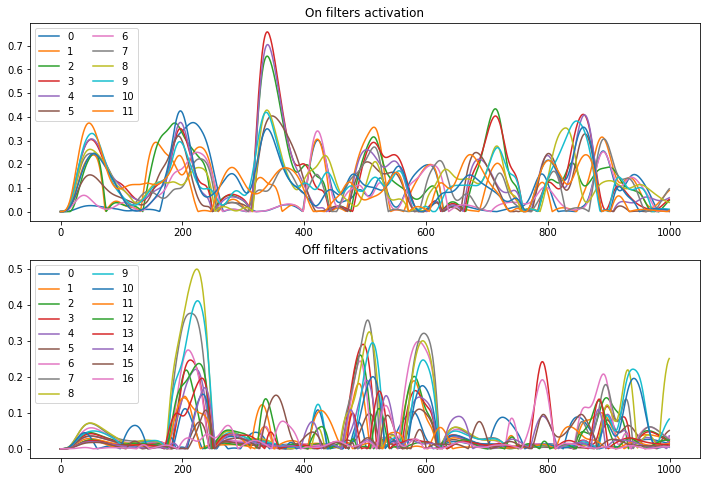

In [12]:
fig, axs = plt.subplots(2, figsize = (12,8))

for i, chan in enumerate(c2c[0]) :
    axs[0].plot(chan, label = i)
    axs[0].legend(loc = 2,ncol = 2)
    axs[0].set_title('On filters activation')
    
for i, chan in enumerate(c2c[1]) :
    axs[1].plot(chan, label = i)
    axs[1].legend(loc = 2,ncol = 2)
    axs[1].set_title('Off filters activations')

# Partie 3 : Saving and loading

In [13]:
def save_currents(savepath, arr_nbr, arr):
    '''
    Uses numpy basic array saving to dump all the currents into a subfolder of the output folder 
    '''
    
    import os
    if not os.path.exists(savepath):
        os.makedirs(savepath)
        
    np.save(savepath+str(arr_nbr)+'.npy', np.asarray(arr))

In [14]:
import datetime
now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")

save_currents('./output/'+strtime+'/', 0, c2c)

In [15]:
loaded_array = np.load('./output/'+strtime+'/'+str(0)+'.npy')

# Partie 4 : Injecter du courant

In [16]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

/home/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


In [17]:
##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': 20.5 #mV - McCormick
                    }

#neuron_params = sim.IF_cond_alpha.default_parameters

st_levels = loaded_array
injection_sampling_rate = 1
current_times = np.linspace(0,total_time,len(st_levels[0][0][::injection_sampling_rate]))
current_list = []

##############
# Simulation #
##############
sim.setup(timestep=0.01)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


#injecting all ON cells current
for inputs in range(len(st_levels[0])):

    current_levels = st_levels[0][inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)

    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()
    
#injecting all OFF cells current
for inputs in range(len(st_levels[1])):

    current_levels = st_levels[1][inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)

    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()
    
post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v = post.get_data().segments[0]
sig = post_v.analogsignals[0]

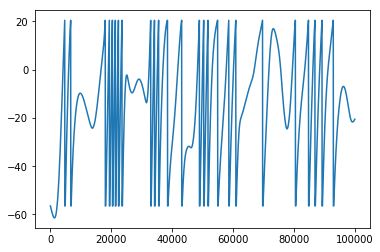

In [18]:
plt.plot(sig)

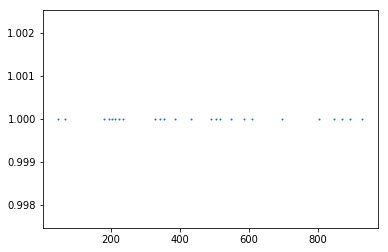

In [19]:
plt.scatter(post_v.spiketrains, np.ones_like(post_v.spiketrains), s = 1)

# MULTITHREADING TIME
## 1/ Multithreader la génération de positions de filtres
Il faut réécrire un peu le code, la fonction est en dessous :
TODO : End the joblib parallelisation.

In [86]:
def generate_small_gabors_coordinates_multithread(theta,params, N_X, N_Y,  centers_coordinates, nbr_gabors=6,
                                      B_theta=15, sf_0=.05, B_sf=.5,
                                      distrib_size=8, grid_res=3, on_thresh=.1, off_thresh=-.1,
                                      verbose=True):
    '''
    Multithreading modification : we pass the theta as an argument
    
    Given some gabor parameters, a set of coordinates for centering gabors, returns a set of 
    coordinates for filters belonging into the gabors

    The code iterates through thetas and generate nbr_gabors set of ON/OFF filters

    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        centers_coordinates : a 2D array containing two list of coordinates for
                                centering the gabors
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape, 
                                B_theta being the opening of the gabor, sf_0 the spatia frequency 
                                and b_sf the bandwidth frequency
    '''

    xs = centers_coordinates[0]
    ys = centers_coordinates[1]

    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta / 180 * np.pi
    params = {'sf_0': sf_0, 'B_sf': B_sf, 'B_theta': B_theta}

    filters_per_theta = []

    phi = np.zeros((1, N_phase, N_X, N_Y))
    params.update(theta=theta)

    filters_per_gab = []
    for gab in range(nbr_gabors):
        x = xs[gab]
        y = ys[gab]

        for i_phase in range(N_phase):
            phase = i_phase * np.pi/2
            kernel = lg.invert(lg.loggabor(
                x, y, **params)*np.exp(-1j*phase))
            phi[0, i_phase, :] = lg.normalize(kernel)

        fx_min = x - distrib_size
        fx_max = x + distrib_size
        fy_min = y - distrib_size
        fy_max = y + distrib_size
        filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,
                                       fy_min:fy_max:grid_res].reshape(2, -1).T
        if verbose and gab == 0:
            print('Thread started !\nFilter grid shape', filters_coordinates.shape, '\n')

        filters_in_gabor = gabor_connectivity(filters=filters_coordinates,
                                              phi=phi, theta=0, threshold=on_thresh)
        off_filters_in_gabor = gabor_connectivity(filters=filters_coordinates,
                                                  phi=phi, theta=0, threshold=off_thresh, on=False)

        filters_per_gab.append((filters_in_gabor, off_filters_in_gabor))

    

    return filters_per_gab

In [87]:
from joblib import Parallel, delayed

gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                        'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                        'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                        'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                        'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                        'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                        'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                        'white_recompute': False, 'white_steepness': 4.0}

distrib_size = 8
grid_res = 3
N_theta = 12
centers_coordinates = np.array(
    [[35, 20, 35, 10, 20, 35], [35, 20, 10, 35, 35, 20]])

filters_multithread = Parallel(n_jobs=-1, backend='loky')(delayed(generate_small_gabors_coordinates_multithread)
                    (theta,
                     params=gabors_parameterfile, N_X=54, N_Y=54,
                     centers_coordinates=centers_coordinates,
                     distrib_size=distrib_size, grid_res=grid_res)
                        for theta in np.linspace(0, np.pi, N_theta))

In [88]:
np.asarray(filters_multithread).shape

(12, 6, 2)

## 2/ Multithreader la génération de courant
Toujours besoin de réécrire la fonction

In [23]:
def coordinates_to_currents_multithread(filters,
                            stimuli, total_time, filter_size, filter_res):
    '''
    Multithreading modification : filters are passed together then separeted in the function,
    to ease the iterators on the Joblib Delayed decorator
    
    Creates currents from spatiotemporal filters in given coordinates set, by convolving
    the apex of the ST filter with the receptive field in a fed video

    Args :
        filters_in_gabor : a set of coordinates for ON CENTER RFs
        off_filters_in_gabor : a set of coordinates for OFF CENTER RFs

        stimulus = a video transformed into a numpy array (see the associated .py file)
                    must be (WxHxlen) shape
        total_time = total time of the current simulation, usually equal to the stimulus length

        filter_size, filter_res = spatiotemporal filters arguments
                                    other parameters have been optimized and are left by default

    '''
    levels_per_gabor = []
    for gabors in filters : #iterate through the six gabor per filter
        
        filters_in_gabor, off_filters_in_gabor = gabors[0], gabors[1] #simple as that
        # a number of aborted filters due to edge-closeness
        err_nbr = 0

        # LES FILTRES ON

        st_list = []
        on_st_levels = []

        for filt in range(len(filters_in_gabor)):
            try:
                X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                         xres=filter_res, yres=filter_res,
                                         x_trans=filters_in_gabor[filt][0],
                                         y_trans=filters_in_gabor[filt][1])
                t = [temporal_filter(i)
                     for i in np.linspace(0, total_time, total_time)]

                # Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, total_time):
                    activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                              * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]


                st_list.append(st)

                on_st_level = []
                for i in range(total_time):
                    on_st_level.append(np.max(st[:, :, i]))
                on_st_levels.append(on_st_level)
            except:
                err_nbr += 1
                pass

        # LES FILTRES OFF
        st_list = []
        off_st_levels = []

        for filt in range(len(off_filters_in_gabor)):
            try:
                X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                         xres=filter_res, yres=filter_res,
                                         x_trans=off_filters_in_gabor[filt][0],
                                         y_trans=off_filters_in_gabor[filt][1],
                                         end_multiplier=1.)
                t = [temporal_filter(i)
                     for i in np.linspace(0, total_time, total_time)]

                # Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, total_time):
                    activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                              * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]

)
                st_list.append(st)

                off_st_level = []
                for i in range(total_time):
                    off_st_level.append(np.max(st[:, :, i]))
                off_st_levels.append(off_st_level)
            except:
                err_nbr += 1
                pass

        if err_nbr > 0:
            print('Due to misplacement, %s / %s filters were removed' %
                  (err_nbr, (len(filters_in_gabor)+len(off_filters_in_gabor))))
        levels_per_gabor.append((on_st_levels, off_st_levels))

    return levels_per_gabor

In [146]:
from joblib import Parallel, delayed

gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                        'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                        'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                        'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                        'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                        'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                        'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                        'white_recompute': False, 'white_steepness': 4.0}

total_time = 1000
filter_size = 2.
filter_res = .1

video = np.load('../montypython.npy')
video = np.rot90(video)

#this generates all the currents for ONE theta only, 15 s per theta, so I infer 180s runtime
#with theta-based loop : 

currents_multithread = Parallel(n_jobs=-1, backend='loky')(delayed(coordinates_to_currents_multithread)
                              (filters,
                               stimuli=video, total_time=total_time,
                               filter_size=filter_size, filter_res=filter_res)
                                for filters in filters_multithread)


In [147]:
np.asarray(currents_multithread).shape

(12, 6, 2)

In [104]:
import datetime
now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")

save_currents('./output/'+strtime+'/', 0, currents_multithread)

In [130]:
len(currents_multithread[1][0][0][0][::5])

200

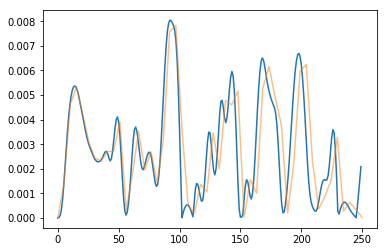

In [151]:
plt.plot(currents_multithread[1][0][0][0])#current for second theta, first gabor, on filters, first on filter

#théorème de shannon, on a pas besoin d'échantillonner plus que 2 fois la fréquence du plus petit evenement
#1 AP = 1 ms, donc on peut descendre à 120Hz si besoin. On prend 200 pour etre large ?
plt.plot(np.linspace(0,250,50),currents_multithread[1][0][0][0][::5], alpha = .5)

In [136]:
len(currents_multithread[0][0][0])

0

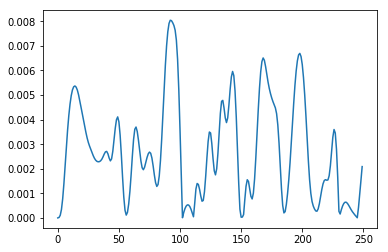

In [148]:
plt.plot(currents_multithread[1][0][0][0])